In [ ]:
COLAB = True

In [ ]:
import numpy as np
import json

from IPython.display import JSON, Audio
import base64
import io
import librosa
import librosa.display

from tqdm import tqdm

from scipy.signal import butter,filtfilt

from scipy.io.wavfile import read as wr
from scipy.io.wavfile import write as ww

import matplotlib.pyplot as plt
%matplotlib inline

!pip install pydub

from pydub import AudioSegment

In [ ]:
if COLAB:
    from google_drive_downloader import GoogleDriveDownloader as gdd
    gdd.download_file_from_google_drive(file_id='1mamOwllpoOilUHMrXhBrY9azktQMME3q',
                                        dest_path='./datos_taidy/ml_data.json')

In [ ]:
!ls

datos_taidy  sample_data


In [ ]:
!ls datos_taidy

ml_data.json


In [ ]:
with open('./datos_taidy/ml_data.json') as f:
    data = json.load(f)

data[0].keys()

dict_keys(['id', 'created_at', 'audio', 'labels'])

In [ ]:
len(data)

87

In [ ]:
data[76]["labels"]

{'breaths': [{'end': 6.781626891126148, 'start': 6.335651427628322}],
 'end_number': [{'number': '30'}],
 'numbers': {'10': {'end': 2.799845959179182,
   'original_length': 12.117333333333333,
   'start': 2.5138616933487374},
  '7': {'end': 1.7859017439621498,
   'original_length': 12.117333333333333,
   'start': 1.575913297023711},
  'End (30)': {'end': 11.36898023715415,
   'original_length': 12.117333333333333,
   'start': 11.021393629311767},
  'Start (1)': {'end': 0.1639909776090664,
   'original_length': 12.117333333333333,
   'start': 1.3877787807814457e-17}},
 'others': [{'label': 'Spanish', 'name': 'language'},
  {'label': 'Male', 'name': 'gender'}],
 'start_number': [{'number': '1'}],
 'text': []}

In [ ]:
JSON(data[0])

<IPython.core.display.JSON object>

In [ ]:
aux = base64.b64decode(data[0]['audio']['data'].encode('utf-8'))
Audio(aux)

In [ ]:
#target_sr = 48000
target_sr = 22500

sounds = []

for dat in tqdm(data):
    aux = base64.b64decode(dat['audio']['data'].encode('utf-8'))
    ext = dat["audio"]["s3"].split(".")[-1]
    sound = AudioSegment.from_file(io.BytesIO(aux), format=ext).set_channels(1).set_frame_rate(target_sr)
    sound = sound.compress_dynamic_range(threshold=-40)
    #sound = sound.normalize()
    sounds.append(sound)

100%|██████████| 87/87 [02:44<00:00,  1.89s/it]


In [ ]:
len(sounds)

87

(272640,)

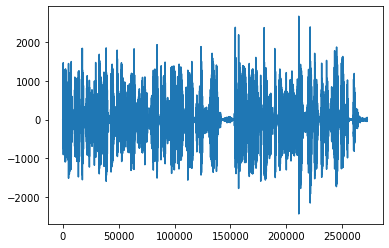

In [ ]:
sound = sounds[76]
num = np.array(sound.get_array_of_samples())

plt.plot(num);
num.shape

In [ ]:
sr = sound.frame_rate

sr, sound.channels, len(num) / sr

(22500, 1, 12.117333333333333)

In [ ]:
sound

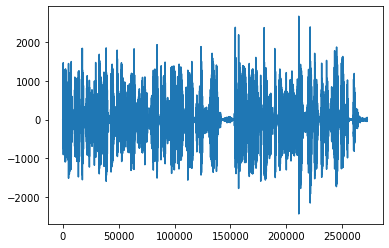

In [ ]:
plt.plot(num);

In [ ]:
sound

In [ ]:
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = fs/2
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def normalizar(x, secs_ventana=2, fs=44100):
    x2 = x.copy().astype(float)
    samples_ventana = int(secs_ventana*fs)
    aux = max(np.abs(x[:samples_ventana]).max(), 1)
    x2[:samples_ventana] = x2[:samples_ventana] / aux
    
    for i in range(samples_ventana, len(x2)):
        aux = max(np.abs(x[(i+1-samples_ventana):(i+1)]).max(), 1)
        x2[i] = x2[i] / aux
    return x2

def preprocesa(fichero_orig, fichero_dest):
    Fs, x = wr(fichero_orig)
    
    if len(x.shape) > 1:
        x = x[:,0]
        
    #x2 = normalizar(x, secs_ventana=1, fs=Fs)
    x2 = normalizar(x, secs_ventana=0.5, fs=Fs) # este funciona bien
    #x2 = normalizar(x, secs_ventana=0.2, fs=Fs)
    #x2 = normalizar(x, secs_ventana=0.1, fs=Fs)

    #x2 = normalizar(butter_lowpass_filter(x, 7000, Fs, 10), secs_ventana=1, fs=Fs)

    x2 = x2 / np.abs(x2).max()
    x2 = x2 * 30000 # / 4 / 4
    x2 = x2.astype(np.int16)
    #x3 = np.zeros((len(x2),2), dtype=np.int16)
    #x3[:,0] = x2; x3[:,1] = x2

    ww(fichero_dest, Fs, x2)

In [ ]:
caso = 76
sound = sounds[caso]
num = np.array(sound.get_array_of_samples())

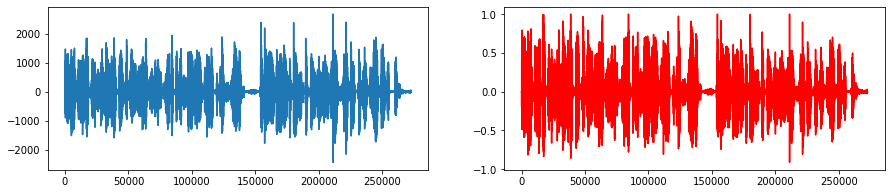

In [ ]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1)
plt.plot(num)
plt.subplot(1,2,2)
num_norm = normalizar(num, secs_ventana=2, fs=sr)
plt.plot(num_norm, "r");

In [ ]:
Audio(num, rate=sr)

In [ ]:
Audio(num_norm, rate=sr)

In [ ]:
#caso = 76
#num = normalizar(np.array(sounds[caso].get_array_of_samples()), secs_ventana=2, fs=sr)

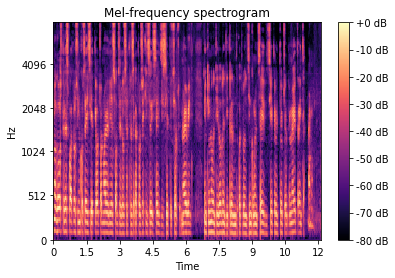

In [ ]:
S = librosa.feature.melspectrogram(y=num_norm, sr=sr, n_mels=128,
                                   fmax=8000)

fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                               y_axis='mel', sr=sr,
                               fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram');

In [ ]:
S_dB.shape

(128, 533)

In [ ]:
"""
import os
import glob
import pyAudioAnalysis
from pyAudioAnalysis import audioBasicIO as aIO
#from pyAudioAnalysis import audioSegmentation as aS
from pyAudioAnalysis.audioSegmentation import train_hmm_from_directory, hmm_segmentation

"""

'\nimport os\nimport glob\nimport pyAudioAnalysis\nfrom pyAudioAnalysis import audioBasicIO as aIO\n#from pyAudioAnalysis import audioSegmentation as aS\nfrom pyAudioAnalysis.audioSegmentation import train_hmm_from_directory, hmm_segmentation\n\n'

In [ ]:
# Ejemplo de cargar audio con librosa
#path = './audio.mp3'
#with open(path, 'wb') as f:
#    f.write(base64.b64decode(data[76]['audio']['data'].encode('utf-8')))
#y, sr = librosa.load(path)

In [ ]:
?librosa.feature.melspectrogram

In [ ]:
hop_length = 100
n_fft = 2048
n_mels = 128
fmax = 8000

S = librosa.feature.melspectrogram(y=num_norm, sr=sr, n_mels=n_mels,
                                   fmax=fmax, hop_length=hop_length, n_fft=n_fft)
S_dB = librosa.power_to_db(S, ref=np.max)
S_dB.shape

(128, 2727)

In [ ]:
int(np.ceil(len(num_norm) / hop_length)) # debería ser igual que el segundo número anterior

2727

In [ ]:
target_sr, n_fft / target_sr, hop_length / target_sr

(22500, 0.09102222222222223, 0.0044444444444444444)

In [ ]:
len(num_norm), hop_length * (4953-1)

(272640, 495200)

In [ ]:
ts_centros = [hop_length*i/target_sr for i in range(S_dB.shape[1])]
ts_centros[-10:]

[12.075555555555555,
 12.08,
 12.084444444444445,
 12.088888888888889,
 12.093333333333334,
 12.097777777777777,
 12.102222222222222,
 12.106666666666667,
 12.11111111111111,
 12.115555555555556]

- length breath: 0.4459754634978266 seconds
100


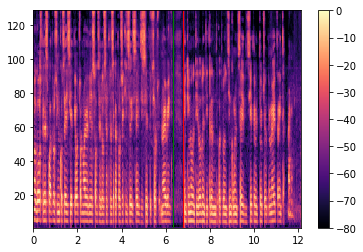

In [ ]:
fig, ax = plt.subplots()
img = ax.pcolormesh(np.arange(0,S_dB.shape[1],1)*hop_length/target_sr,
                    np.arange(0.5, 128+1, 1),
                    S_dB, cmap="magma",
                    vmin=-80, vmax=0)
for breath in data[caso]["labels"]["breaths"]:
    plt.plot(2*[breath["start"]], [0.5,128], "g", linewidth=1)
    plt.plot(2*[breath["end"]], [0.5,128], "r", linewidth=1)
    print("- length breath:", breath["end"]-breath["start"], "seconds")
    print(len([1 for i in ts_centros if (i>=breath["start"]) and (i<breath["end"])]))
fig.colorbar(img);

In [ ]:
0.4459754634978266*target_sr / 100

100.34447928701098

In [ ]:
len(num_norm)/target_sr

12.117333333333333

In [ ]:
data[caso]["labels"]

{'breaths': [{'end': 6.781626891126148, 'start': 6.335651427628322}],
 'end_number': [{'number': '30'}],
 'numbers': {'10': {'end': 2.799845959179182,
   'original_length': 12.117333333333333,
   'start': 2.5138616933487374},
  '7': {'end': 1.7859017439621498,
   'original_length': 12.117333333333333,
   'start': 1.575913297023711},
  'End (30)': {'end': 11.36898023715415,
   'original_length': 12.117333333333333,
   'start': 11.021393629311767},
  'Start (1)': {'end': 0.1639909776090664,
   'original_length': 12.117333333333333,
   'start': 1.3877787807814457e-17}},
 'others': [{'label': 'Spanish', 'name': 'language'},
  {'label': 'Male', 'name': 'gender'}],
 'start_number': [{'number': '1'}],
 'text': []}

In [ ]:
len(num) / target_sr

12.117333333333333

In [ ]:
ts_centros[-5:]

[12.097777777777777,
 12.102222222222222,
 12.106666666666667,
 12.11111111111111,
 12.115555555555556]

In [ ]:
hop_length = 100
#hop_length = 500
n_fft = 2048
n_mels = 128
fmax = 8000

halfwidth  = n_fft / 2 / target_sr
margen = 0.05

In [ ]:
hop_length / sr

0.0044444444444444444

In [ ]:
window = 50*5
#window = 20 # con hop_length=500

window_t = (window-1)*hop_length / target_sr
window_t

1.1066666666666667

In [ ]:
X = []
y = []
ids = []

for dat,sound in tqdm(zip(data, sounds)):

    num = np.array(sound.get_array_of_samples())
    sr = sound.frame_rate
    num_norm = normalizar(num, secs_ventana=2, fs=sr)

    S = librosa.feature.melspectrogram(y=num_norm, sr=sr, n_mels=n_mels,
                                      fmax=fmax, hop_length=hop_length, n_fft=n_fft)
    S_dB = librosa.power_to_db(S, ref=np.max)

    N = S_dB.shape[1]
    
    ts_centros = [hop_length*i/target_sr for i in range(S_dB.shape[1])]

    breaths = dat["labels"]["breaths"]
    for i,t in enumerate(ts_centros[:-window]):
        is_breath = False
        near_breath = False
        t0 = t - halfwidth
        t1 = t + window_t + halfwidth
        for breath in breaths:
            
            if max(t0+margen, breath["start"]) < min(t1-margen, breath["end"]):
                #print("- BREATH")
                #print("  ts interval:", t0, t1)
                #print("  ts breath:", breath["start"], breath["end"])
                is_breath = True
                X.append(S_dB[:,i:(i+window)].T)
                y.append(1)
                ids.append(dat["id"])
                break

            if max(t0-margen, breath["start"]) < min(t1+margen, breath["end"]):
                near_breath = True

        if (not is_breath) and (not near_breath):
            #print("- NO BREATH")
            #print("  ts interval:", t0, t1)
            X.append(S_dB[:,i:(i+window)].T)
            y.append(0)
            ids.append(dat["id"])
        
        if (not is_breath) and near_breath:
            #print("- NEAR BREATH")
            #print("  ts interval:", t0, t1)
            pass


87it [14:03,  9.69s/it]


In [ ]:
len(X)

184946

In [ ]:
#np.array(X).shape

In [ ]:
np.mean(y)

0.019346187535821267

In [ ]:
sum(y)

3578

In [ ]:
#X = np.array(X)

In [ ]:
len(np.unique(ids))

87

In [ ]:
X1   = [x for x,clase in zip(X,y) if clase==1]
ids1 = [id_ for id_,clase in zip(ids,y) if clase==1]
len(X1), len(ids1)

(3578, 3578)

In [ ]:
len(np.unique(ids1))

8

In [ ]:
n = 0
for dat in data:
    if len(dat["labels"]["breaths"]) > 0:
        #print(dat["id"])
        n += 1
n

8

In [ ]:
aux = np.random.permutation(range(len(ids)))
X0   = []
ids0 = []
n1 = len(X1)
n  = 0
for i in aux:
    if y[i]==0:
        X0.append(X[i])
        ids0.append(ids[i])
        n += 1
        if n == 2*n1:
            break

len(X0)

7156

In [ ]:
unique0 = list(np.unique(ids0))
unique1 = list(np.unique(ids1))

ids_test = unique0[-2:] + unique1[-2:]
ids_val  = unique0[-3:-2] + unique1[-3:-2]
ids_tr   = unique0[:-3] + unique1[:-3]

print(ids_val)
print(ids_test)

['sources/31-12-2020_17:20:30-28647eee-4e7a-4e3d-a9c8-b8785e71d0ff', 'sources/17-01-2021_12:30:30-c3f6bf90-eb3e-48ae-82ca-346408d3ff15']
['sources/31-12-2020_19:44:00-4941d5d5-fb24-4d07-add9-00bb1077bd75', 'sources/31-12-2020_19:46:31-a803d8b4-075a-4722-a56d-a628fba6b4cb', 'sources/20-01-2021_17:22:01-ed926e96-fad9-4fd1-b32f-dc81d37da2a2', 'sources/27-01-2021_10:34:56-aa24ac34-badf-417a-85d0-fa320cb4f632']


In [ ]:
X0_tr   = [x for i,x in zip(ids0,X0) if i in ids_tr]
X1_tr   = [x for i,x in zip(ids1,X1) if i in ids_tr]

X0_val  = [x for i,x in zip(ids0,X0) if i in ids_val]
X1_val  = [x for i,x in zip(ids1,X1) if i in ids_val]

X0_test = [x for i,x in zip(ids0,X0) if i in ids_test]
X1_test = [x for i,x in zip(ids1,X1) if i in ids_test]

len(X0_tr), len(X1_tr), len(X0_val), len(X1_val), len(X0_test), len(X1_test)

(6938, 3578, 179, 307, 446, 612)

In [ ]:
factor = 100

X_tr    = X0_tr + X1_tr
y_tr    = len(X0_tr)*[0] + len(X1_tr)*[1]
X_tr    = np.array(X_tr) / factor
y_tr    = np.array(y_tr)

X_val   = X0_val + X1_val
y_val   = len(X0_val)*[0] + len(X1_val)*[1]
X_val   = np.array(X_val) / factor
y_val   = np.array(y_val)

X_test  = X0_test + X1_test
y_test  = len(X0_test)*[0] + len(X1_test)*[1]
X_test  = np.array(X_test) / factor
y_test  = np.array(y_test)

In [ ]:
from keras.models import Sequential, load_model, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Activation, Dropout, Flatten, Dense, GlobalAveragePooling1D
from keras.layers import AveragePooling1D, Dropout
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras import regularizers

from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

In [ ]:
"""
# Arquitectura de la red:

model = Sequential()
model.add(Conv1D(filters=10, input_shape=X_tr[0].shape, #padding="same",
                 kernel_size=(5,), activation='relu'))
model.add(MaxPooling1D(pool_size=(2,)))
model.add(Conv1D(filters=10, kernel_size=(5,), activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dropout(rate=0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

# Rellenar arquitectura

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

"""

In [ ]:
# Arquitectura de la red:

model = Sequential()
model.add(Conv1D(filters=64, input_shape=X_tr[0].shape, #padding="same",
                 kernel_size=(5,), activation='relu'))
model.add(MaxPooling1D(pool_size=(2,)))
model.add(Conv1D(filters=32, kernel_size=(5,), activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters=16, kernel_size=(5,), activation='relu'))
model.add(MaxPooling1D())
model.add(GlobalAveragePooling1D())
model.add(Dropout(rate=0.5))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

# Rellenar arquitectura

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 246, 64)           41024     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 123, 64)           0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 119, 32)           10272     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 59, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 55, 16)            2576      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 27, 16)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)               

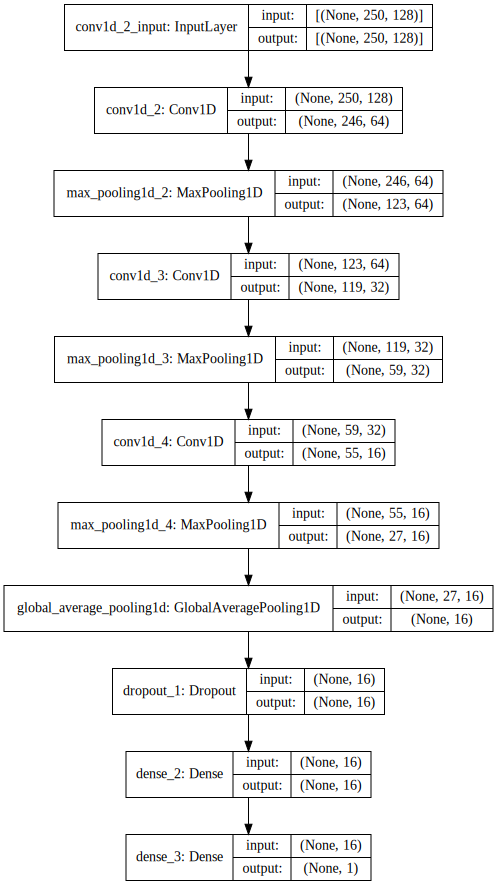

In [ ]:
# graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True, dpi=72
                 ).create(prog='dot', format='svg'))

In [ ]:
batch_size = 16

In [ ]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [ ]:
acum_tr_acc = []
acum_val_acc = []
best_val_acc = -1000
best_val_loss = 1e20
acum_tr_loss  = []
acum_val_loss = []

optimiza_accuracy = False

if optimiza_accuracy:
    monitor='val_accuracy'
    mode='max'
else:
    monitor='val_loss'
    mode='min'

modelpath="best_model.h5"

checkpoint = ModelCheckpoint(modelpath,
                             monitor=monitor,
                             verbose=1,
                             save_best_only=True,
                             mode=mode) # graba sólo los que mejoran en validación
callbacks_list = [checkpoint]

In [ ]:
X_val.shape

(486, 250, 128)

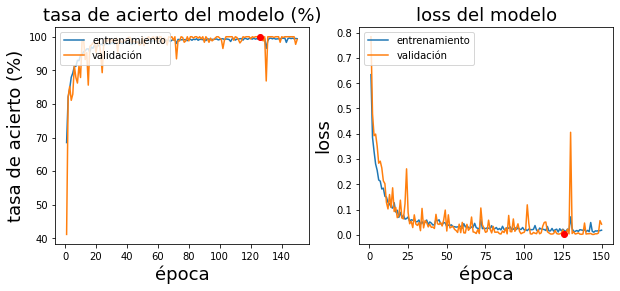

In [72]:
epochs = 50

for e in range(epochs):
    history = model.fit(X_tr, y_tr, 
                        epochs=1,
                        callbacks=callbacks_list,
                        batch_size=batch_size,
                        verbose=1,
                        shuffle=True,
                        validation_data=(X_val,y_val)
                       )
    
    if optimiza_accuracy:
        if history.history['val_accuracy'][-1] > best_val_acc:
            print("Validation accuracy improved from",
                  best_val_acc, 'to', history.history['val_accuracy'])
            print("saving weights")
            best_val_acc = history.history['val_accuracy'][-1]
    else:
        if history.history['val_loss'][-1] < best_val_loss:
            print("Validation loss improved from",
                best_val_loss, 'to', history.history['val_loss'])
            print("saving weights")
            best_val_loss = history.history['val_loss'][-1]
    
    acum_tr_acc.append(history.history['accuracy'][0])
    acum_val_acc.append(history.history['val_accuracy'][0])
    acum_tr_loss.append(history.history['loss'][0])
    acum_val_loss.append(history.history['val_loss'][0])
    
    if len(acum_tr_acc) > 1:
        clear_output()
        if optimiza_accuracy:
            best_i = np.argmax(acum_val_acc)
        else:
            best_i = np.argmin(acum_val_loss)
        grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [ ]:
aaa

NameError: ignored

In [73]:
!ls -la

total 712
drwxr-xr-x 1 root root   4096 Mar 15 20:21 .
drwxr-xr-x 1 root root   4096 Mar 15 19:54 ..
-rw-r--r-- 1 root root 705288 Mar 15 20:32 best_model.h5
drwxr-xr-x 4 root root   4096 Mar  5 14:36 .config
drwxr-xr-x 2 root root   4096 Mar 15 19:56 datos_taidy
drwxr-xr-x 1 root root   4096 Mar  5 14:37 sample_data


In [74]:
model = load_model(modelpath)

## **Resultados obtenidos**

In [75]:
scores_tr = model.evaluate(X_tr, y_tr)
print('Train loss    :', scores_tr[0])
print('Train accuracy:', scores_tr[1])
print()

scores_val = model.evaluate(X_val, y_val)
print('Val loss    :', scores_val[0])
print('Val accuracy:', scores_val[1])
print()

scores_te = model.evaluate(X_test, y_test)
print('Test loss     :', scores_te[0])
print('Test accuracy :', scores_te[1])

329/329 [==============================] - 2s 5ms/step - loss: 0.0068 - accuracy: 0.9991
Train loss    : 0.0067892419174313545
Train accuracy: 0.9991441369056702

16/16 [==============================] - 0s 4ms/step - loss: 0.0028 - accuracy: 1.0000
Val loss    : 0.0027983682230114937
Val accuracy: 1.0

34/34 [==============================] - 0s 6ms/step - loss: 0.0062 - accuracy: 0.9991
Test loss     : 0.006174824666231871
Test accuracy : 0.9990548491477966


In [76]:
y_pred_proba = model.predict(X_test)
y_pred_proba.shape

(1058, 1)

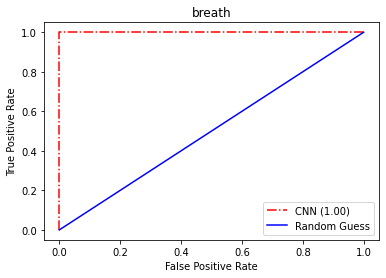

In [77]:
nombre_clase = "breath"

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:,0])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.set_title(nombre_clase)
ax1.legend()
plt.show()

In [78]:
def predict(dat, threshold=0.5):
    aux = base64.b64decode(dat['audio']['data'].encode('utf-8'))
    ext = dat["audio"]["s3"].split(".")[-1]
    sound = AudioSegment.from_file(io.BytesIO(aux), format=ext).set_channels(1).set_frame_rate(target_sr)
    sound = sound.compress_dynamic_range(threshold=-40)
    #sound = sound.normalize()

    num = np.array(sound.get_array_of_samples())
    sr = sound.frame_rate
    num_norm = normalizar(num, secs_ventana=2, fs=sr)

    S = librosa.feature.melspectrogram(y=num_norm, sr=sr, n_mels=n_mels,
                                      fmax=fmax, hop_length=hop_length, n_fft=n_fft)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    ts_centros = [hop_length*i/target_sr for i in range(S_dB.shape[1])]

    for i in range(S_dB.shape[1]-window):
        inp = np.array([S_dB[:,i:(i+window)].T]) / 100
        #print("INPUT SHAPE:", inp.shape)
        p = model.predict(inp)[0]
        #print("P(BREATH):", p)
        if p>threshold:
            print("P={}, BREATH IN [{}, {}]".format(p,ts_centros[i]-halfwidth,
                                                    ts_centros[i]+window_t+halfwidth))
            print("  id: {}".format(dat["id"]))
            print("  breaths: {}".format(dat["labels"]["breaths"]))

In [81]:
for id_test in ids_test:
    for caso, dat in enumerate(data):
        if dat["id"]==id_test:
            break
    
    predict(data[caso], threshold=0.9)

P=[0.9253067], BREATH IN [9.323377777777779, 10.521066666666668]
  id: sources/20-01-2021_17:22:01-ed926e96-fad9-4fd1-b32f-dc81d37da2a2
  breaths: [{'start': 10.671587268437948, 'end': 10.92757736783076}]
P=[0.97847885], BREATH IN [9.327822222222222, 10.525511111111111]
  id: sources/20-01-2021_17:22:01-ed926e96-fad9-4fd1-b32f-dc81d37da2a2
  breaths: [{'start': 10.671587268437948, 'end': 10.92757736783076}]
P=[0.98982376], BREATH IN [9.332266666666667, 10.529955555555556]
  id: sources/20-01-2021_17:22:01-ed926e96-fad9-4fd1-b32f-dc81d37da2a2
  breaths: [{'start': 10.671587268437948, 'end': 10.92757736783076}]
P=[0.99301165], BREATH IN [9.33671111111111, 10.5344]
  id: sources/20-01-2021_17:22:01-ed926e96-fad9-4fd1-b32f-dc81d37da2a2
  breaths: [{'start': 10.671587268437948, 'end': 10.92757736783076}]
P=[0.9944306], BREATH IN [9.341155555555556, 10.538844444444445]
  id: sources/20-01-2021_17:22:01-ed926e96-fad9-4fd1-b32f-dc81d37da2a2
  breaths: [{'start': 10.671587268437948, 'end': 10.9

In [ ]:
def myplay(id_):
    for dat in data:
        if dat["id"] == id_:
            break
    
    aux = base64.b64decode(dat['audio']['data'].encode('utf-8'))
    ext = dat["audio"]["s3"].split(".")[-1]
    sound = AudioSegment.from_file(io.BytesIO(aux), format=ext).set_channels(1).set_frame_rate(target_sr)
    sound = sound.compress_dynamic_range(threshold=-40)
    #sound = sound.normalize()

    num = np.array(sound.get_array_of_samples())
    sr = sound.frame_rate
    num_norm = normalizar(num, secs_ventana=2, fs=sr)

    display(Audio(num_norm, rate=sr))


In [ ]:
myplay("sources/20-01-2021_17:22:01-ed926e96-fad9-4fd1-b32f-dc81d37da2a2")